Import Libraries

In [4]:
import os
import sys
import numpy as np
import scipy.io
import scipy.misc
import tensorflow as tf  # Import TensorFlow after Scipy or Scipy will break
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
%matplotlib inline

This pre-trained network can be downloaded [here](http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat). I did not include it in the repository because it is 500 MB.

In [2]:
from vgg_config import load_vgg_model
vgg = load_vgg_model('imagenet-vgg-verydeep-19.mat')

- Content (c)
- Style (s)
- Generated (g)


### Visualizing What a deep network is learning
[Zeiler and Fergus, 2013, Visualizing and Understanding Convolutional Networks]

Gist: Pick a unit in layer 1. Find the nine image patches that maximize that unit's activation.

### Cost Function
[Gatys et al., 2015. A neural algorithm of artistic style]
- Use Gradient descent to minimize J(G) = alpha * Jcontent(C, G) + beta* Jstyle(S, G)
- Steps:
    - 1: Initiate G randomly (G: [100 x 100 x 3] matrix)
    - 2: Use gradient descent to minimize J(G)
    - 3: Repeat
#### Content cost:
- Say you use hidden layer *l* to compute content cost
    - Use pre-trained ConvNet (e.g. VGG network)
    - Let a^[l](C) and a^[l](G) be the activation of layer l on the images
    - If a^[l](C) and a^[l](G) are similar, both images have similar content

#### Style cost:
- Take a layer of the network and visualize the different components as described in vid 2. Take correlations between each component (e.g. do vertical lines correspond with orange colors?)


# Current todo's
- Visualize hidden layers for content vs style
- Source / expand description for VGG19
- Compare eager execution vs. fast style transfer
- Texture transfer

# Load images

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

In [6]:
import tensorflow as tf
#import tensorflow.contrib.eager as tfe

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [7]:
#tf.enable_eager_execution()

In [8]:
def load_img(path_to_img, max_dim = 512):
    """
    purpose: 
        Reshape an input image into dimensions compatible with VGG19 model
    
    details:
        1) Load image
        2) Resize to maximum dimension size
        3) Store image in numpy array
        4) Convert 3D image into 4D via np.expand()
        
    args:
        path_to_img (string)    file location of image
        max_dim     (integer)   maximum dimensions for rescaling large images
        
    rets:
        img         (np array)  rescaled 4D image array
    """
    img = Image.open(path_to_img)
    long = max(img.size)
    scale = max_dim/long

    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
    img = kp_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    
    return img


def imshow(img, ax, title=None):
    """
    purpose:
        -Remove 4th dimension from image array, plot via
        matplotlib.pyplot.imshow()
        
    args:
        img    (np array)    4D representation of image
        ax     (plt Axes)    Location of plotted image
        title  (string)      Title for plotted image
    """
    out = np.squeeze(img, axis=0).astype('uint8')
    ax.tick_params(labelbottom=False, labelleft=False)
    ax.imshow(out)
    if title:
        ax.set_title(title)    
        

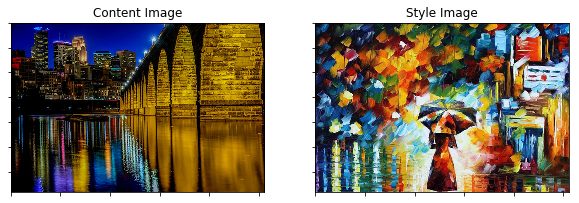

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))

content = load_img('data/content/stonearch.jpg').astype('uint8')
_, w, h, _ = content_image.shape

style = load_img('data/style/rainPrincess.jpg').astype('uint8')
style = style[:,:w, :h, :] # resize to same dimensions

imshow(content, ax[0], 'Content Image')
imshow(style, ax[1], 'Style Image')
plt.show()

# Preprocess Data

If you've used Photoshop or similar software, you are probably used to the RGB convention of images. The [VGG Networks](https://arxiv.org/pdf/1409.1556.pdf) works with BGR instead. It also preprocesses the images by normalizing BGR through subtracting [103.939, 116.779, 123.68]

In [10]:
def load_and_process_img(path_to_img):
    """
    purpose:
        apply vgg19 preprocessing to image
    args:
        path_to_img   (string)   file location of image
    rets:
        img           (np array) 4D representation of image
    """
    img = load_img(path_to_img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_img(processed_img):
    """
    purpose:
        reverse vgg19 preprocessing
    details:
        -add [103.939, 116.779, 123.68] to respective BGR vectors
        -remove 4th dimension from image
    args:
        processed_img (4D np array)
    rets:
        img (3D np array)
    """
    img = processed_img.copy()
    if len(img.shape) == 4:
        img = np.squeeze(img, 0)
    else:
        raise ValueError("Invalid input to deprocessing image")

    img[:, :, 0] += 103.939 # Blue
    img[:, :, 1] += 116.779 # Green
    img[:, :, 2] += 123.68  # Red
    img = img[:, :, ::-1]   # 4D to 3D

    img = np.clip(img, 0, 255).astype('uint8')
    return img

todo - visualize content layers & style layers

# Build Model

todos - change maxpool layers to average pool

Following the original [NST paper](https://arxiv.org/pdf/1508.06576.pdf), we will use the [VGG-19 Network](https://arxiv.org/pdf/1409.1556.pdf)

In [11]:
#vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
#vgg.trainable = False

![VGG19 - Clifford K. Yang](img/vgg19.jpg)

The *Visual Geometry Group* (VGG) has published this pre-trained model, which gets its name from the 16 convolutional layers + 3 fully-connected layers. Its original purpose was image classification - it can detect 1,000 different objects in an image.

We are not interested in image classification, however, because this model was trained on over 1-million images from the [ImageNet](http://www.image-net.org/) database, it can effectively separate low-level features (at the earlier layers) from the high level features (at the deeper layers)

![arxiv - 1508.06576 - Figure 1](img/1508.06576.fig-1.png)

### Style Reconstructions:
A feature space is built on top of the filter responses for each layer in 

Recall that a digital image is a 3-dimensional vector (traditionally RGB, but defined as BGR in this model). The output of each layer also produces a BGR vector. We compare the correlations between each of these layers to define the style. An image can then be reconstructed based on the representations built on subsets of CNN layers:

**(a)**: conv1_1 

**(b)**: conv1_1 and conv2_1 

**(c)**: conv1_1, conv2_1 and conv3_1

**(d)**: conv1_1, conv2_1, conv3_1 and conv4_1 

**(e)**: conv1_1, conv2_1, conv3_1, conv4_1 and conv5_1

### Content Reconstructions:
The lower layers (**a, b, c**) reproduce seemingly identical pixels of the input image, whereas the higher layers (**d, e**) capture the *content* of the image, but do not constrain the exact pixel values.
**(a)** - conv1_1, **(b)** - conv2_1 ,**(c)** - conv3_1, **(d)** - conv4_1, **(e)** - conv5_1

In [50]:
styleDict = {
    'a': ['conv1_1'],
    'b': ['conv1_1', 'conv2_1'],
    'c': ['conv1_1', 'conv2_1', 'conv3_1'],
    'd': ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1'],
    'e': ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']   
}

contentLayer = 'conv4_2'

# Cost Functions

### Content Loss
We want our generated image to have content which is similar to the content image. As such, we need to define a loss function so that the neural network knows how "close" it is to the original content image. 

Given a hidden layer (in this case, using block4_conv2), we take the sum of squared error - where the error is defined as the difference in activations between the content image and the generated image. Following the convention used in the original NST paper, we will define our loss as follows:


$$J_{content}(C,G) =  \frac{1}{4 \times height \times width \times channels}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2$$



In [26]:
def compute_content_cost(content_activations, generated_activations):
    """
    purpose:
        For a **single layer's** activations, compute the cost between a generated
        image and the original content image
    
    details:
        - As described in arXiv:1508.06576, compute the cost as:
        
                    (1 / 4 * height * width * channels) * 
            sum( (content_activation - generated_activation) ^2 )
 
    args:
        content_activations   (4D array)
            - numpy representation of content image's activations
            
        generated_activations (4D array)
            - numpy representation of generated image's activations
    
    rets:
        Sum of squared errors, multiplied by (1/4 * height * width * channels)
    """
    
    m, height, width, channels = generated_activations.get_shape().as_list()
    
    return (1 / 4 * height * width * channels) *  tf.reduce_sum(tf.square(content_activations - generated_activations))


### Style Loss - Gram Matrices
Recall that a [gram matrix](https://en.wikipedia.org/wiki/Gramian_matrix) is calculated by taking the dot product of a matrix transposed by itself. Andrew Ng has a helpful visualization in his coursera series on Convolutional Neural Networks:

![Andrew Ng - Gram Matrix](img/andrew_ng_gram.png)

In [13]:
def gram_matrix(A):
    """
    args:
        A: - matrix of shape (n_c, n_H*n_W)
    rets:
        Gram Matrix of A, shape (n_C, n_C)
    """
    return tf.matmul(A, tf.transpose(A))

The style cost function is essentially the same as the content cost function, with two changes:

1) The sum of squared error is now with regard to the two gram matrices

2) The channels, height, and width in the denominator are squared

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2$$

In [14]:
def compute_single_style_cost(style_activations, generated_activations):
    """
    purpose:
        For a **single** hidden layer's activations, compute the cost between a
        generated image and the original style image

    details:
        - 1) Create a gram matrix for both activations
        - 2) Compute the cost, as described above
        
    args:
        style_activations   (4D array)
            - numpy representation of content image's activations
            
        generated_activations (4D array)
            - numpy representation of generated image's activations
    
    rets:
        Sum of squared errors, multiplied by (1/4 * channels^2 * (height * width)^2 )
    """
    
    m, height, width, channels = generated_activations.get_shape().as_list()
    
    
    # reshape into 2 dimensional matrix, then transform into gram matrix
    style_activations = tf.transpose(tf.reshape(style_activations,
                                               (height*width, channels)))
    
    generated_activations = tf.transpose(tf.reshape(generated_activations,
                                                   (height*width, channels)))
    
    style_gram = gram_matrix(style_activations)
    generated_gram = gram_matrix(generated_activations)
    #return height,width, channels
    cost =  (1 / 4 * channels**2, (height * width)**2) * \
            (tf.reduce_sum(tf.square(tf.subtract(style_gram, generated_gram))))
    return cost
    

In [47]:
def compute_avg_style_cost(model, style_layers):
    """
    purpose:
        Compute the average style loss for a given model, across given layers

    details:
        - For each layer in style_layers(), gather the activations from 
        
    args:
    
    rets:
       
    """
    # calculate cost for each activation
    costList = []
    for layer in style_layers:
        out = model[layer]
        style_activation = sess.run(out)
        generated_activation = out
        costList.append(compute_single_style_cost(style_activation,
                                                 generated_activation))
    avgCost = sum(costList) / len(costList)
    
    return avgCost


Now we weight and combine the two cost functions to give us our overall loss:

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [16]:
def compute_total_cost(content_loss, style_loss, alpha=10, beta=40):
    """
    purpose:
        Compute the average style loss for a given model, across given layers

    details:
        - For each layer in style_layers(), gather the activations from 
        
    args:
    
    rets:
       
    """
    total_loss = alpha*content_loss + beta*style_loss
    return total_loss

At each epoch, we compare the style and content of the generated image, and adjust the pixels accordingly. We begin by generating an image which is slightly correlated with the content image, but contains a lot of noise.

In [59]:
def add_noise_to_image(image, ratio):
    """
    purpose:
        add ratio % noise to an image
    details:
        - create a random numpy array with same dimensions as input image
        - add (noise * ratio) + (image * 1-ratio)
    args:
        image (np array) original image
        ratio (float)    decimal representation of % noise to add
    rets:
        (np array) image with noise added
    
    """
    noise = np.random.uniform(-20, 20, (image.shape)).astype('float32')
    
    return (noise * ratio) + (image * (1 - ratio))

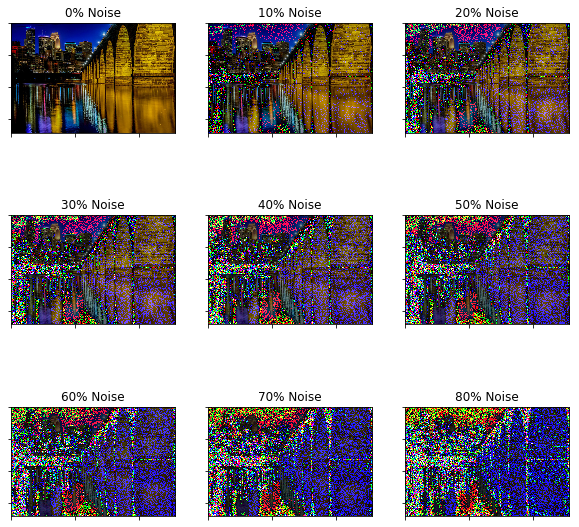

In [18]:
fig, ax = plt.subplots(3, 3, figsize=(10,10))

noise_pct = 0.0
for x in range(3):
    for y in range(3):
        noisy_img = add_noise_to_image(content, noise_pct)
        imshow(noisy_img, ax[x][y], '{0:.0%} Noise'.format(noise_pct))
        noise_pct+= 0.1

In [19]:
sess = tf.InteractiveSession()

In [29]:
style_image.shape, content_image.shape

((1, 512, 511, 3), (1, 342, 512, 3))

In [32]:
ax, fi
imshow(style_image, ax[0][0])

In [53]:
content_path = 'data/content/stonearch.jpg'
style_path = 'data/style/rainPrincess.jpg'
content_layer = 'conv4_2'
content_image = load_and_process_img(content_path)
content_image = content_image[:, :w, :h-1, :]

style_image = load_and_process_img(style_path)
style_image = style_image[:, :w, :h-1, :]

vgg = load_vgg_model('imagenet-vgg-verydeep-19.mat', content_image.shape)
sess.run(vgg['input'].assign(content_image))

content_activation = sess.run(vgg[content_layer])
generated_activation = vgg[content_layer] # placeholder for now. will be updated later
content_cost = compute_content_cost(content_activation, generated_activation)

sess.run(vgg['input'].assign(style_image))
style_cost = compute_avg_style_cost(vgg, styleDict['e'])

total_cost = compute_total_cost(content_cost, style_cost,
                                alpha=10, beta=40)

optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(total_cost)

In [75]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    ### START CODE HERE ### (1 line)
    sess.run(tf.global_variables_initializer())
    ### END CODE HERE ###
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    ### START CODE HERE ### (1 line)
    sess.run(vgg['input'].assign(input_image))
    ### END CODE HERE ###
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        ### START CODE HERE ### (1 line)
        sess.run(train_step)
       ### END CODE HERE ###
        
        # Compute the generated image by running the session on the current vgg['input']
        ### START CODE HERE ### (1 line)
        generated_image = sess.run(vgg['input'])
        ### END CODE HERE ###

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([total_cost, content_cost, style_cost])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            path = "output/" + str(i) + ".png"
            scipy.misc.imsave(path, deprocess_img(generated_image))
    
    # save last generated image
#    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [76]:
generated_image = add_noise_to_image(content_image, ratio=0.6)
model_nn(sess, generated_image)

Iteration 0 :
total cost = [nan nan]
content cost = nan
style cost = [nan nan]


/Users/morgann/anaconda3/envs/foo/lib/python3.6/site-packages/ipykernel/__main__.py:35: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Iteration 20 :
total cost = [nan nan]
content cost = nan
style cost = [nan nan]


KeyboardInterrupt: 

In [78]:
model = vgg
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [79]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, style_layers)

NameError: name 'compute_style_cost' is not defined

In [81]:
compute_avg_style_cost(model, styleDict['e']).value

AttributeError: 'Tensor' object has no attribute 'value'

In [17]:
content_outputs = [vgg.get_layer(name).output for name in [contentLayer]]
model_content = models.Model(vgg.input, content_outputs)
#out = model

In [ ]:
content_img = content
#tf.reset_default_graph()
#sess = tf.InteractiveSession()
nn_input = tf.contrib.eager.Variable(np.zeros((content_img.shape)), dtype = 'float32')
sess.run(nn_input.assign(content_img))
#content_outputs = [vgg.get_layer(name).output for name in [contentLayer]]
#model_content = models.Model(vgg.input, content_outputs)
a_C = sess.run(model_content)


In [26]:
def run_style_transfer(content_path,
                       style_path,
                       init_noise_ratio,
                       model,
                       content_layer,
                       style_layers,
                       num_iterations=200,
                       content_weight=10,
                       style_weight=40):
    for layer in model.layers:
        layer.trainable = False

    # initialize images
    content_img = load_and_process_img(content_path)
    style_img = load_and_process_img(style_path)
    generated_img = add_noise_to_image(content_img, init_noise_ratio)
    generated_img = tf.Variable(generated_img, dtype=tf.float32)
    
    # define content model
    content_outputs = [model.get_layer(name).output for name in [contentLayer]]
    model_content = models.Model(model.input, content_outputs)
    
    # Define Optimizer
    opt = tf.train.AdamOptimizer(2.0)
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means 
    
    for i in range(num_iterations):
        content_activations = model_content(content_img)
        gen_content_activations = model_content(generated_img)
        
        content_cost = compute_content_cost(content_activations, generated_content_activations)
        style_cost = compute_avg_style_cost(model, style_layers, style_img, generated_img)
        
        with tf.GradientTape() as tape:
            total_cost = compute_total_cost(content_cost, style_cost,
                                            content_weight, style_weight)
            
        grads = tape.gradient(total_cost, generated_img)
        opt.apply_gradients([(grads, generated_img)])
        clipped = tf.clip_by_value(generated_img, min_vals, max_vals)
        generated_img.assign(clipped)
    return generated_image
        

In [27]:
content_path = 'data/content/stonearch.jpg'
style_path = 'data/style/rainPrincess.jpg'
ayy = run_style_transfer(content_path,
                       style_path,
                       init_noise_ratio=0.6,
                       model=vgg,
                       content_layer = contentLayer,
                       style_layers = styleDict['e'],
                       num_iterations=2,
                       content_weight=10,
                       style_weight=40)

AttributeError: 'numpy.ndarray' object has no attribute 'get_shape'

In this notebook, we will initialize the beginning image to contain 60% noise. Choosing a different % of noise will correspond with a different final generated image.

In [85]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=200,
                       content_weight=1e3, 
                       style_weight=1e-2): 
 
    model = get_model() 
    for layer in model.layers:
        layer.trainable = False
  
    # Get the style and content feature representations (from our specified intermediate layers) 
    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    # Set initial image
    init_image = load_and_process_img(content_path)
    init_image = tfe.Variable(init_image, dtype=tf.float32)
    # Create our optimizer
    opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

    # For displaying intermediate images 
    iter_count = 1

    # Store our best result
    best_loss, best_img = float('inf'), None

    # Create a nice config 
    loss_weights = (style_weight, content_weight)
    cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
    }

    # For displaying
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations/(num_rows*num_cols)
    start_time = time.time()
    global_start = time.time()

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   

    imgs = []
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time() 
    
        if loss < best_loss:
            # Update best loss and best image from total loss. 
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

        if i % display_interval== 0:
            start_time = time.time()

            # Use the .numpy() method to get the concrete numpy array
            plot_img = init_image.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Iteration: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
                'style loss: {:.4e}, '
                'content loss: {:.4e}, '
                'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
    print('Total time: {:.4f}s'.format(time.time() - global_start))
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    for i,img in enumerate(imgs):
        plt.subplot(num_rows,num_cols,i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
      
    return best_img, best_loss 

# Viusalize Content Features
- todo: expand on content dimensions
- 

In [ ]:
model = get_model() 
for layer in model.layers:
    layer.trainable = False

# Get the style and content feature representations (from our specified intermediate layers) 
style_features, content_features = get_feature_representations(model, 'data/content/stonearch.jpg', 'data/style/rainPrincess.jpg')
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

In [39]:
content_layers

['block5_conv2']

'block3_conv3'

In [14]:
# Extracts the outputs of all layers
layer_outputs = [layer.output for layer in model.layers]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    """This function will compute the loss total loss.

    Arguments:
    model: The model that will give us access to the intermediate layers
    loss_weights: The weights of each contribution of each loss function. 
      (style weight, content weight, and total variation weight)
    init_image: Our initial base image. This image is what we are updating with 
      our optimization process. We apply the gradients wrt the loss we are 
      calculating to this image.
    gram_style_features: Precomputed gram matrices corresponding to the 
      defined style layers of interest.
    content_features: Precomputed outputs from defined content layers of 
      interest.

    Returns:
    returns the total loss, style loss, content loss, and total variational loss
    """
    style_weight, content_weight = loss_weights

    # Feed our init image through our model. This will give us the content and 
    # style representations at our desired layers. Since we're using eager
    # our model is callable just like any other function!
    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    # Accumulate style losses from all layers
    # Here, we equally weight each contribution of each loss layer
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
    style_score *= style_weight
    content_score *= content_weight

    # Get total loss
    loss = style_score + content_score 
    return loss, style_score, content_score

In [ ]:
def compute_grads(cfg):
    with tf.GradientTape() as tape: 
        all_loss = compute_loss(**cfg)
    # Compute gradients wrt input image
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

In [65]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=200,
                       content_weight=1e3, 
                       style_weight=1e-2): 
 
    model = get_model() 
    for layer in model.layers:
        layer.trainable = False
  
    # Get the style and content feature representations (from our specified intermediate layers) 
    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    # Set initial image
    init_image = load_and_process_img(content_path)
    init_image = tfe.Variable(init_image, dtype=tf.float32)
    # Create our optimizer
    opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

    # For displaying intermediate images 
    iter_count = 1

    # Store our best result
    best_loss, best_img = float('inf'), None

    # Create a nice config 
    loss_weights = (style_weight, content_weight)
    cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
    }

    # For displaying
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations/(num_rows*num_cols)
    start_time = time.time()
    global_start = time.time()

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   

    imgs = []
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time() 
    
        if loss < best_loss:
            # Update best loss and best image from total loss. 
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

        if i % display_interval== 0:
            start_time = time.time()

            # Use the .numpy() method to get the concrete numpy array
            plot_img = init_image.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Iteration: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
                'style loss: {:.4e}, '
                'content loss: {:.4e}, '
                'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
    print('Total time: {:.4f}s'.format(time.time() - global_start))
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    for i,img in enumerate(imgs):
        plt.subplot(num_rows,num_cols,i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
      
    return best_img, best_loss 

In [ ]:
content_path = 'data/content/stonearch.jpg'
style_path = 'data/style/rainPrincess.jpg'

best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=1000)

# Sources:

### Content:
[Stonearch Bridge](https://www.flickr.com/photos/11375428@N04/16995175861)

### Style:
[Rain Princess](https://afremov.com/images/product/RAIN-PRINCESS.jpg)


### Code:
[Neural Style Transfer - Raymond Yuan](https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398)


### Theory:
https://arxiv.org/pdf/1508.06576.pdf